In [1]:
# TODO2 Can battery have an economic system?
# TODO State areas where the teams could innovate on the model
# TODO add owner and economic receipts
# TODO add crowdfunders
# TODO add maintenance

In [2]:
# cadCAD Open Questions

# 1. Is it possible to run substeps (PSubs) in a non-deterministic order? Or order that was determined by a function that's output changes each step?
# 2. How to best handle variables that are only relevant in the step? Or across substeps?
# 3. Can you update multiple state variables in a single policy without doing this silly dictionary pass I've done? Or is it possible to immediately update the state variable itself instead of waiting for state update?
# 4. Can initial conditions be non-deterministic? Can I pass in a random number generator that acts as the dataset, and will it generate new random numbers each Monte Carlo run?

# Power to the People Hackathon
## Energy System Dynamics

### Import Libraries

In [3]:
import random
import math
import numpy as np

### Set Initial Conditions

In [4]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# List of all the state variables in the system and their initial values
initial_conditions = {
    # INITIAL CONDITIONS TO PLAY WITH
    'bat_lim': 25, # max kWh able to be stored in battery
    'price_per_kwh': {'price': 0.07, 'max_price': 0.13, 'min_price': 0.0}, # EUR cents
    # INITIAL CONDITIONS TO LET BE
    # total tracking of max values
    'energy_prod': {'available': 0., 'remaining': 0.}, # total energy produced by the system per timestep
    'energy_appetite': {'priority': 0., 'business': 0., 'leisure': 0.}, # amount of energy appetite
    # total tracking of actual usage
    'energy_cons': {'tot': 0, 'prod': 0., 'bat_use': 0., 'priority': 0., 'business': 0., 'leisure': 0., 'bybat': 0}, # total energy consumed
    # time tracking
    'hour': 0,
    # track time-based variances
    'annual_var': {'prod': 0., 'priority': 0., 'business': 0., 'leisure': 0.},
    'daily_mult': {'prod': .8, 'priority': .8, 'business': .8, 'leisure': .8},
    # limited mechanics tracking
    'bat_level': 0, # amount of energy currently stored in the battery  
}
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

### Set Simulation Parameters

In [5]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# Settings of general simulation parameters, unrelated to the system itself
# `T` is a range with the number of discrete units of time the simulation will run for;
# `N` is the number of times the simulation will be run (Monte Carlo runs)
# `M` is not currently used
days_to_simulate = 5

simulation_parameters = {
    'T': range(24*days_to_simulate),
    'N': 1,
    'M': {}
}
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

### Generate Data Functions

In [6]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# Specify the energy generation and usage functions

def hourly_production_capacity(params, step, sL, s):
    hourly_0_prod_chance = 0.1
    hour = s['hour']
    # set cosine function attributes
    y_int = 33 # tuned to make energy output over year match reported 59000 per Solartainer
    cos_mult = 2.
    x_mult = 1./365/24*2*np.pi
    # get variances
    # get annual mu
    if hour % (365*24) == 0:
        mu, sigma = y_int, .03 * y_int
        annual_var = np.random.normal(mu, sigma, 1)[0]
    else:
        annual_var = s['annual_var']['prod']
    # get daily mu
    # daily (multiplier)
    if hour % 24 == 0:
        mu, sigma = 0.8, .2
        daily_mult = abs(np.random.normal(mu, sigma, 1)[0])
    else:
        daily_mult = s['daily_mult']['prod']
    # hourly var
    mu, sigma = annual_var, .1 * annual_var
    hourly_var = np.random.normal(mu, sigma, 1)[0]
    # hourly mult
    hourly_mult = max(np.sin((hour)/24*2*np.pi - np.pi/2) + 0.5, 0)
    if random.random() < hourly_0_prod_chance:
        hourly_mult = 0
    # get core waveform
    prod = ((cos_mult * np.cos(step * x_mult) + hourly_var) * daily_mult) * hourly_mult
    # set limits
    prod = max(0, prod) # must be >= 0
    prod = min(prod, y_int) # maximum generation capacity of equipment per hour
    return(prod, annual_var, daily_mult)

def hourly_usage_appetite(params, step, sL, s, tier):
    hour = s['hour']
    # get different cosine manipulators for each tier of user
    if tier == 'priority':
        y_int = 9
        annual_var = s['annual_var']['priority']
        daily_mult = s['daily_mult']['priority']
        daily_mult_sigma = 0.01
        cos_mult = 0.1
        hourly_cos_mult = 0.1
        hourly_sig = 0.01
    if tier == 'business':
        y_int = 3 / (s['price_per_kwh']['price'] / s['price_per_kwh']['max_price'])
        annual_var = s['annual_var']['business']
        daily_mult = s['daily_mult']['business']
        daily_mult_sigma = 0.1
        cos_mult = 0.5
        hourly_cos_mult = 0.8
        hourly_sig = 0.1
    if tier == 'leisure':
        y_int = 3 / (s['price_per_kwh']['price'] / s['price_per_kwh']['max_price'])
        annual_var = s['annual_var']['leisure']
        daily_mult = s['daily_mult']['leisure']
        daily_mult_sigma = 0.2
        cos_mult = 1.2
        hourly_cos_mult = 1.0
        hourly_sig = 0.2
    # set cosine function attributes
    x_mult = 1./365/24*2*np.pi
    # get variances
    # get annual mu
    if hour % (365*24) == 0:
        mu, sigma = y_int, .03 * y_int
        annual_var = np.random.normal(mu, sigma, 1)[0]
    # get daily mu
    # daily (multiplier)
    if hour % 24 == 0:
        mu, sigma = 0.8, daily_mult_sigma
        daily_mult = abs(np.random.normal(mu, sigma, 1)[0])
    # hourly var
    mu, sigma = annual_var, hourly_sig * annual_var
    hourly_var = np.random.normal(mu, sigma, 1)[0]
    # hourly mult
    hourly_mult = max(hourly_cos_mult * (np.sin((hour)/24*4*np.pi - np.pi/2)+0.5*np.sin((hour)/24*2*np.pi - np.pi/2)) + 0.8, 0)
    # get core waveform
    cons = ((cos_mult * np.sin(step * x_mult) + hourly_var) * daily_mult) * hourly_mult
    # set limits
    cons = max(0, cons) # must be >= 0
    cons = min(cons, y_int) # maximum usage appetite per hour
    return(cons, annual_var, daily_mult)

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

### Specify Agent Energy Consumption Functions

In [7]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #  
# Specify the Solartainer production and battery logic in a Policy function
def solartainer_produce(params, step, sL, s):
    # calculate production from random variables
    energy_prod_remaining, annual_var, daily_mult = hourly_production_capacity(params, step, sL, s)
    if s['hour'] % (24*10) == 0: # print day every 10 days
        print("day:", int(s['hour']/24))
    # reset state trackers
    energy_prod_ = s['energy_prod'] # total energy produced by the system per timestep
    energy_prod_['available'] = energy_prod_remaining
    energy_prod_['remaining'] = energy_prod_remaining
    annual_var_ = s['annual_var']
    annual_var_['prod'] = annual_var
    daily_mult_ = s['daily_mult']
    daily_mult_['prod'] = daily_mult
    return({'energy_prod': energy_prod_,
            'annual_var': annual_var_,
            'daily_mult': daily_mult_
            })

# Specify the user of electricity logic in a Policy function
def consume_electricity(params, step, sL, s, energy_appetite, use_bat):
    energy_avail_prod = s['energy_prod']['remaining']
    energy_cons_prod = min(energy_avail_prod, energy_appetite)
    if use_bat:
        energy_cons_bat = min(energy_appetite - energy_cons_prod, s['bat_level'])
    else:
        energy_cons_bat = 0
    return(energy_cons_prod, energy_cons_bat)

def userGroup_usage(params, step, sL, s, tier):
    # calculate energy appetite from random variables, something about the state?
    #energy_appetite = 3 #random.random()*2
    energy_appetite, annual_var, daily_mult = hourly_usage_appetite(params, step, sL, s, tier=tier)
    # consume electricity based on appetite
    energy_cons_prod, energy_cons_bat = consume_electricity(params, step, sL, s, energy_appetite, use_bat=True)
    # prepare dictionaries
    energy_appetite_ = s['energy_appetite']
    energy_appetite_[tier] = energy_appetite
    energy_cons_ = s['energy_cons']
    energy_cons_[tier] = energy_cons_prod + energy_cons_bat
    energy_cons_['tot'] += energy_cons_prod + energy_cons_bat
    energy_cons_['prod'] += energy_cons_prod
    energy_cons_['bat_use'] += energy_cons_bat
    energy_prod_ = s['energy_prod']
    energy_prod_['remaining'] -= energy_cons_prod
    annual_var_ = s['annual_var']
    annual_var_[tier] = annual_var
    daily_mult_ = s['daily_mult']
    daily_mult_[tier] = daily_mult
    return({'energy_appetite': energy_appetite_,
            'energy_cons': energy_cons_, 
            'energy_prod': energy_prod_,
            'bat_use': energy_cons_bat,
            'annual_var': annual_var_,
            'daily_mult': daily_mult_})

# Specify the individual policy functions of the electricity consumers and battery
def userGroup_priority(params, step, sL, s):
    tier = 'priority'
    return userGroup_usage(params, step, sL, s, tier)

def userGroup_business(params, step, sL, s):
    tier = 'business'
    return userGroup_usage(params, step, sL, s, tier)

def userGroup_leisure(params, step, sL, s):
    tier = 'leisure'
    return userGroup_usage(params, step, sL, s, tier)

# Specify the actions of the battery based on leftover electricity
def battery_tracker(params, step, sL, s):
    # calculate energy appetite based on battery cap
    energy_appetite = s['bat_lim'] - s['bat_level']
    # consume electricity based on appetite
    energy_cons_prod, energy_cons_bat = consume_electricity(params, step, sL, s, energy_appetite, use_bat=False)
    #energy_cons_ = s['energy_cons']
    energy_cons_ = s['energy_cons']
    energy_cons_['bybat'] = energy_cons_prod
    energy_cons_['bat_use'] += energy_cons_bat
    energy_cons_['prod'] += energy_cons_prod
    energy_cons_['tot'] += energy_cons_prod + energy_cons_bat
    return({'energy_cons': energy_cons_,
            'bat_use': 0,
            'hour_inc': 1})

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

### Define State Update Functions

In [8]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# We make the state update functions less "intelligent",
# ie. they simply add the amount of electricity produced / consumed

# set    

# update potential max values
def set_energy_prod(params, step, sL, s, _input):
    y = 'energy_prod'
    x = {'available': 0., 'remaining': 0.}
    return (y, x)

def set_energy_appetite(params, step, sL, s, _input):
    y = 'energy_appetite'
    x = {'priority': 0., 'business': 0., 'leisure': 0.}
    return (y, x)

# update actual use values
def set_energy_cons(params, step, sL, s, _input):
    y = 'energy_cons'
    x = {'tot': 0, 'prod': 0., 'bat_use': 0., 'priority': 0., 'business': 0., 'leisure': 0., 'bybat': 0}
    return (y, x)

# increments

def increment_energy_prod(params, step, sL, s, _input):
    y = 'energy_prod'
    x = _input['energy_prod']
    return (y, x)

def increment_energy_appetite(params, step, sL, s, _input):
    y = 'energy_appetite'
    x = _input['energy_appetite']
    return (y, x)

# update actual use values
def increment_energy_cons(params, step, sL, s, _input):
    y = 'energy_cons'
    x = _input['energy_cons']
    return (y, x)

# update battery state
def increment_bat_level(params, step, sL, s, _input):
    y = 'bat_level'
    x = s['bat_level'] + _input['energy_cons']['bybat'] - _input['bat_use']
    return (y, x)

# update input variances
def update_annual_var(params, step, sL, s, _input):
    y = 'annual_var'
    x = _input['annual_var']
    return (y, x)

def update_daily_mult(params, step, sL, s, _input):
    y = 'daily_mult'
    x = _input['daily_mult']
    return (y, x)

# update tracker of hours passed
def increment_hour(params, step, sL, s, _input):
    y = 'hour'
    x = s['hour'] + _input['hour_inc']
    return (y, x)

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# TODO here is where you could play with how some policy updates occur

# update price of electricity
def update_price_per_kwh(params, step, sL, s, _input):
    y = 'price_per_kwh'
    price = max(min(s['price_per_kwh']['price'], s['price_per_kwh']['max_price']),s['price_per_kwh']['min_price']) # make sure in bounds
    x = s['price_per_kwh']
    x['price'] = price
    return (y, x)

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

### Define Partial State Update Blocks

In [9]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# In the Partial State Update Blocks, 
# the user specifies if state update functions will be run in series or in parallel
# and the policy functions that will be evaluated in that block
partial_state_update_blocks = [
    { # Get energy available to be used in this timestep
        'policies': { # The following policy functions will be evaluated and their returns will be passed to the state update functions
            'solartainer_produce': solartainer_produce
        },
        'variables': { # The following state variables will be updated simultaneously
            'energy_prod': set_energy_prod,
            'energy_appetite': set_energy_appetite,
            'energy_cons': set_energy_cons,
            'energy_prod': increment_energy_prod,
            'annual_var': update_annual_var,
            'daily_mult': update_daily_mult,
            'price_per_kwh': update_price_per_kwh
        }
    },
    { # Get priority users usage (Tier 1 users)
        'policies': { # The following policy functions will be evaluated and their returns will be passed to the state update functions
            'userGroup_priority': userGroup_priority
        },
        'variables': { # The following state variables will be updated simultaneously
            'energy_appetite': increment_energy_appetite,
            'energy_cons': increment_energy_cons,
            'bat_level': increment_bat_level,
            'annual_var': update_annual_var,
            'daily_mult': update_daily_mult
        }
    },
    { # Get business users usage (Tier 2 users)
        'policies': { # The following policy functions will be evaluated and their returns will be passed to the state update functions
            'userGroup_business': userGroup_business
        },
        'variables': { # The following state variables will be updated simultaneously
            'energy_appetite': increment_energy_appetite,
            'energy_cons': increment_energy_cons,
            'bat_level': increment_bat_level,
            'annual_var': update_annual_var,
            'daily_mult': update_daily_mult
        }
    },
    { # Get leisure users usage (Tier 3 users)
        'policies': { # The following policy functions will be evaluated and their returns will be passed to the state update functions
            'userGroup_leisure': userGroup_leisure
        },
        'variables': { # The following state variables will be updated simultaneously
            'energy_appetite': increment_energy_appetite,
            'energy_cons': increment_energy_cons,
            'bat_level': increment_bat_level,
            'annual_var': update_annual_var,
            'daily_mult': update_daily_mult
        }
    },
    { # Get battery usage (Tier 4)
        'policies': { # The following policy functions will be evaluated and their returns will be passed to the state update functions
            'battery_tracker': battery_tracker
        },
        'variables': { # The following state variables will be updated simultaneously
            'energy_cons': increment_energy_cons,
            'bat_level': increment_bat_level,
            'hour': increment_hour
        }
    }
]
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

### Run cadCAD

In [10]:
from cadCAD.configuration import Configuration
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# The configurations above are then packaged into a `Configuration` object
config = Configuration(initial_state=initial_conditions, #dict containing variable names and initial values
                       partial_state_update_blocks=partial_state_update_blocks, #dict containing state update functions
                       sim_config=simulation_parameters #dict containing simulation parameters
                      )

from cadCAD.engine import ExecutionMode, ExecutionContext, Executor
exec_mode = ExecutionMode()
exec_context = ExecutionContext(exec_mode.single_proc)
executor = Executor(exec_context, [config]) # Pass the configuration object inside an array
raw_result, tensor = executor.execute() # The `execute()` method returns a tuple; its first elements contains the raw results

raw_result = [d for d in raw_result if d['substep'] == 5]

%matplotlib inline
import pandas as pd
df = np.asarray(raw_result)
df2 = {k: [dic[k] for dic in df] for k in df[0]}
inverts = ['price_per_kwh', 'energy_prod', 'energy_appetite', 'energy_cons', 'annual_var', 'daily_mult']
for invert in inverts:
    df3 = df2.copy()
    df3[invert] = {k: [dic[k] for dic in df2[invert]] for k in df2[invert][0]}
    df2 = df3.copy()
df = df2.copy() 



                            __________   ____ 
          ________ __ _____/ ____/   |  / __ \
         / ___/ __` / __  / /   / /| | / / / /
        / /__/ /_/ / /_/ / /___/ ___ |/ /_/ / 
        \___/\__,_/\__,_/\____/_/  |_/_____/  
        by BlockScience
        
Execution Mode: single_proc: [<cadCAD.configuration.Configuration object at 0x00000202197F87B8>]
Configurations: [<cadCAD.configuration.Configuration object at 0x00000202197F87B8>]
day: 0


### Plot Some Stuff

----------------------------
kwh produced: 1187 of 1687 available which is 70.0 % capacity
total appetite was: 1478
leaving 291 kwh generated by diesel which is 20.0 %


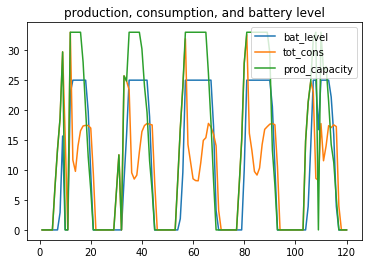

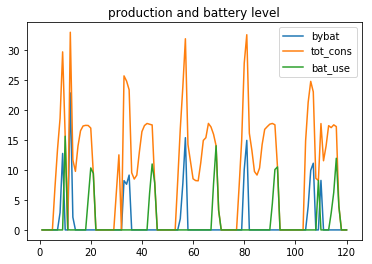

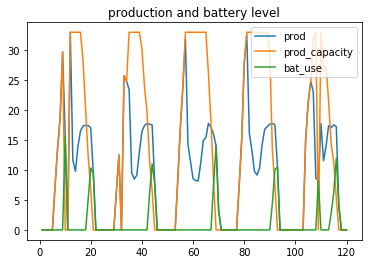

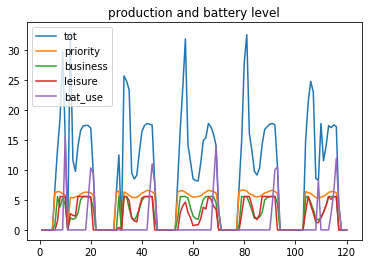

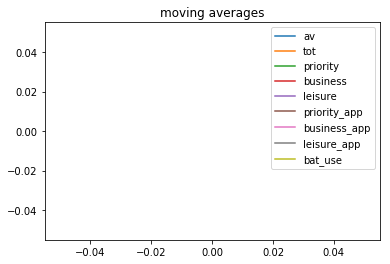

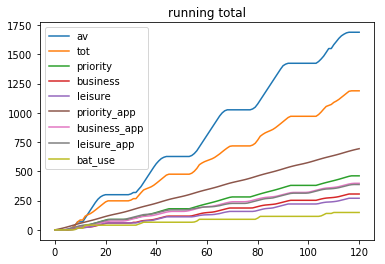

In [11]:
import matplotlib.pyplot as plt

av = int(sum(df['energy_prod']['available']))
tot = int(sum(df['energy_cons']['tot']))
priority = int(sum(df['energy_cons']['priority']))
business = int(sum(df['energy_cons']['business']))
leisure = int(sum(df['energy_cons']['leisure']))
priority_app = int(sum(df['energy_appetite']['priority']))
business_app = int(sum(df['energy_appetite']['business']))
leisure_app = int(sum(df['energy_appetite']['leisure']))
bat_use = int(sum(df['energy_cons']['bat_use']))
bat = int(sum(df['energy_cons']['bybat']))

print('----------------------------')
print('kwh produced:', tot,'of', av,'available which is', np.round(100.*tot/av,),'% capacity')
app_tot = priority_app+business_app+leisure_app
print('total appetite was:', app_tot)
print('leaving', app_tot - tot, 'kwh generated by diesel which is', np.round(100*((app_tot - tot) / app_tot),0),'%')

# TODO connect price of electricity to economic benefit to interested parties?

def moving_average(mylist, N=24*20):
    cumsum, moving_aves = [0], []
    for i, x in enumerate(mylist, 1):
        cumsum.append(cumsum[i-1] + x)
        if i>=N:
            moving_ave = (cumsum[i] - cumsum[i-N])/N
            moving_aves.append(moving_ave)
    return cumsum, moving_aves

av = moving_average(df['energy_prod']['available'])
tot = moving_average(df['energy_cons']['tot'])
priority = moving_average(df['energy_cons']['priority'])
business = moving_average(df['energy_cons']['business'])
leisure = moving_average(df['energy_cons']['leisure'])
priority_ = moving_average(df['energy_appetite']['priority'])
business_ = moving_average(df['energy_appetite']['business'])
leisure_ = moving_average(df['energy_appetite']['leisure'])
bat = moving_average(df['energy_cons']['bybat'])

# plot 
plt.plot(df['timestep'], df['bat_level'], label='bat_level')
plt.plot(df['timestep'], df['energy_cons']['tot'], label='tot_cons')
plt.plot(df['timestep'], df['energy_prod']['available'], label='prod_capacity')
plt.legend()
plt.title('production, consumption, and battery level')
plt.show()

plt.plot(df['timestep'], df['energy_cons']['bybat'], label='bybat')
plt.plot(df['timestep'], df['energy_cons']['tot'], label='tot_cons')
plt.plot(df['timestep'], df['energy_cons']['bat_use'], label='bat_use')
plt.legend()
plt.title('production and battery level')
plt.show()

a = df['energy_appetite']['priority'] + df['energy_appetite']['business'] +  df['energy_appetite']['leisure']
plt.plot(df['timestep'], df['energy_cons']['tot'], label='prod')
plt.plot(df['timestep'], df['energy_prod']['available'], label='prod_capacity')
plt.plot(df['timestep'], df['energy_cons']['bat_use'], label='bat_use')
plt.legend()
plt.title('production and battery level')
plt.show()

plt.plot(df['timestep'], df['energy_cons']['tot'], label='tot')
plt.plot(df['timestep'], df['energy_cons']['priority'], label='priority')
plt.plot(df['timestep'], df['energy_cons']['business'], label='business')
plt.plot(df['timestep'], df['energy_cons']['leisure'], label='leisure')
plt.plot(df['timestep'], df['energy_cons']['bat_use'], label='bat_use')
plt.legend()
plt.title('production and battery level')
plt.show()

plt.plot(av[1], label='av')
plt.plot(tot[1], label='tot')
plt.plot(priority[1], label='priority')
plt.plot(business[1], label='business')
plt.plot(leisure[1], label='leisure')
plt.plot(priority_[1], label='priority_app')
plt.plot(business_[1], label='business_app')
plt.plot(leisure_[1], label='leisure_app')
plt.plot(bat[1], label='bat_use')
plt.legend()
plt.title('moving averages')
plt.show()

plt.plot(av[0], label='av')
plt.plot(tot[0], label='tot')
plt.plot(priority[0], label='priority')
plt.plot(business[0], label='business')
plt.plot(leisure[0], label='leisure')
plt.plot(priority_[0], label='priority_app')
plt.plot(business_[0], label='business_app')
plt.plot(leisure_[0], label='leisure_app')
plt.plot(bat[0], label='bat_use')
plt.legend()
plt.title('running total')
plt.show()


### Sandbox

1106127.521651849 916623.8588012956
Moving Average plots


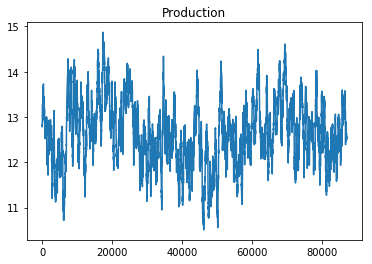

priority


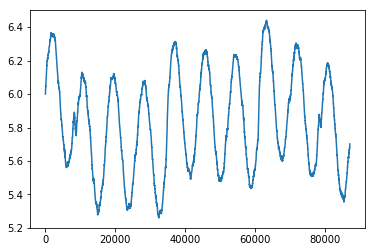

business


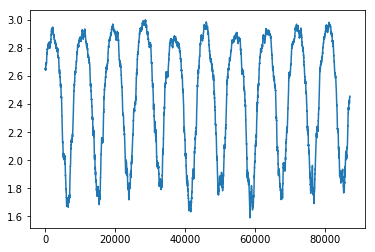

leisure


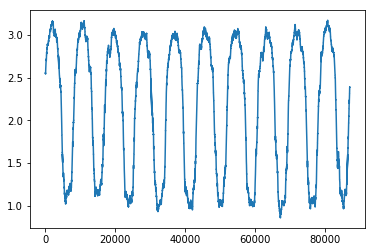

Cumulative Sum plots


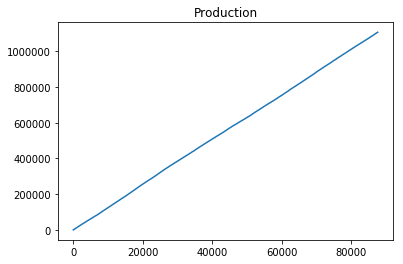

priority


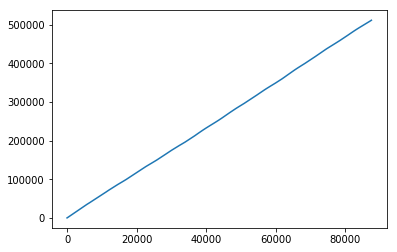

business


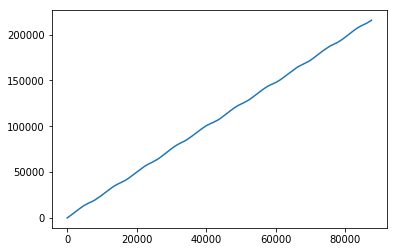

leisure


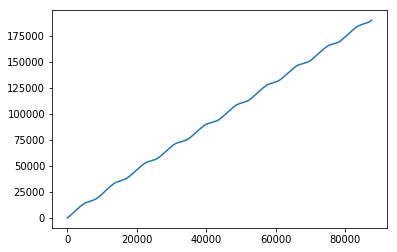

In [12]:
import math
import numpy as np
prods = []
conss_p = []
conss_b = []
conss_l = []
s = {
    'daily_mult': {'prod': 0.8, 'priority': 0.8, 'business': 0.8, 'leisure': 0.8},
    'annual_var': {'prod': 0., 'priority': 0., 'business': 0, 'leisure': 0},
    'hour': 0,
    'price_per_kwh': {'price': 0.09, 'max_price': 0.13, 'min_price': 0.0},
    'max_price_per_kwh': 0.13
}
for x in range(0, 24*365*10):
    prod, annual_var, daily_mult = hourly_production_capacity(None, x, None, s)
    s['daily_mult']['prod'] = daily_mult
    s['annual_var']['prod'] = annual_var
    cons_p, daily_mult, annual_var = hourly_usage_appetite(None, x, None, s, 'priority')
    s['daily_mult']['priority'] = daily_mult
    s['annual_var']['priority'] = annual_var
    cons_b, daily_mult, annual_var = hourly_usage_appetite(None, x, None, s, 'business')
    s['daily_mult']['business'] = daily_mult
    s['annual_var']['business'] = annual_var
    cons_l, daily_mult, annual_var = hourly_usage_appetite(None, x, None, s, 'leisure')
    s['daily_mult']['leisure'] = daily_mult
    s['annual_var']['leisure'] = annual_var
    s['hour'] += 1
    prods.append(prod)
    conss_p.append(cons_p)
    conss_b.append(cons_b)
    conss_l.append(cons_l)
    
print(sum(prods), sum(conss_p)+sum(conss_b)+sum(conss_l))

prods_cum, prods_avg = moving_average(prods)
conss_p_cum, conss_p_avg = moving_average(conss_p)
conss_b_cum, conss_b_avg = moving_average(conss_b)
conss_l_cum, conss_l_avg = moving_average(conss_l)

    
import matplotlib.pyplot as plt

print("Moving Average plots")
plt.plot(prods_avg)
plt.title('Production')
plt.show()
print("priority")
plt.plot(conss_p_avg)
plt.show()
print("business")
plt.plot(conss_b_avg)
plt.show()
print("leisure")
plt.plot(conss_l_avg)
plt.show()

print("Cumulative Sum plots")
plt.plot(prods_cum)
plt.title('Production')
plt.show()
print("priority")
plt.plot(conss_p_cum)
plt.show()
print("business")
plt.plot(conss_b_cum)
plt.show()
print("leisure")
plt.plot(conss_l_cum)
plt.show()